# Measuring Process Conformance with Footprint Conformance and Token based Replay Fitness

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
#!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery


# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.footprints import visualizer as fp_visualizer
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# conformance
from pm4py.algo.conformance.footprints import algorithm as fp_conformance
from pm4py import conformance_diagnostics_token_based_replay
from pm4py.algo.conformance.alignments.edit_distance import algorithm as logs_alignments

# misc 
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.petri_net.obj import PetriNet, Marking

import pm4py

### Read event log

In [3]:
fn = 'ArtificialPatientTreatment.csv'
events = pd.read_csv(fn)

events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])


In [4]:
eventlog = events.copy()
### Specify which columns correspond to case (case:concept:name), 
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)


### Footprint from log

In [5]:
# footprint analysis
fp_log = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)

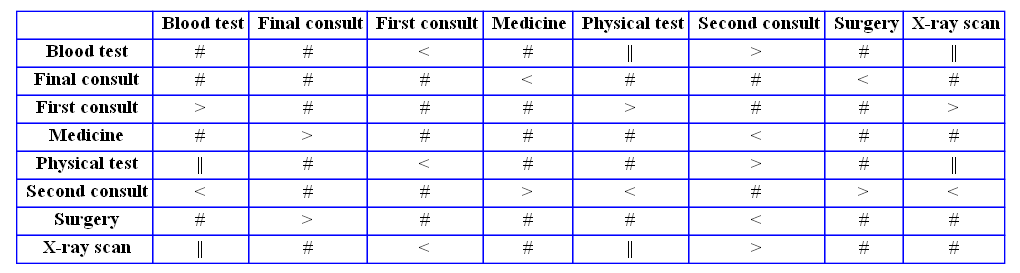

In [6]:
# caution: arrows mean "causality" here NOT "follows"
gviz = fp_visualizer.apply(fp_log)
fp_visualizer.view(gviz)

### Discover process model based on top traces

In [14]:
filtered_log = pm4py.filter_variants_by_coverage_percentage(log, 0.1)
filtered_log

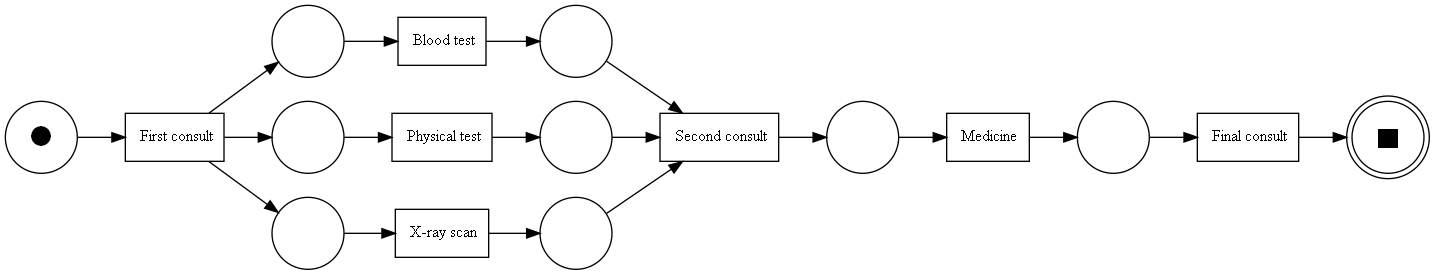

In [16]:
# alpha miner
net, initial_marking, final_marking = alpha_miner.apply(filtered_log)

# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

### Footprint of the discovered process model

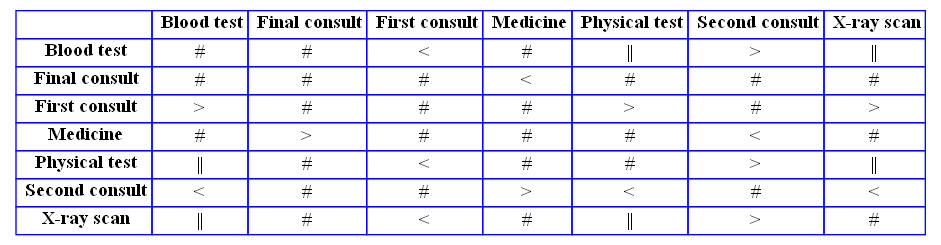

In [17]:
fp_net = footprints_discovery.apply(net, initial_marking, final_marking)
gviz = fp_visualizer.apply(fp_net)
fp_visualizer.view(gviz)

### Visual comparison of log footprint with footprint from normative model

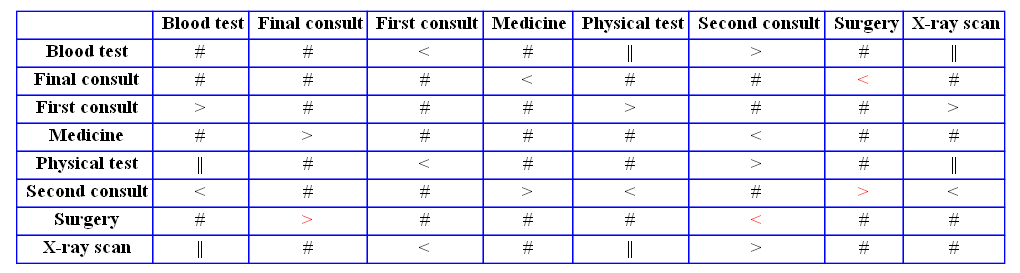

In [18]:
# visualize deviations between log and net footprints
# NOTE: if there are none you will not see anything
gviz = fp_visualizer.apply(fp_log, fp_net)
fp_visualizer.view(gviz)

### Footprint Conformance between Log Footprint and Footprint from Normative Model

In [19]:
conf_result = fp_conformance.apply(fp_log, fp_net, variant=fp_conformance.Variants.LOG_EXTENSIVE)
conf_result

{'footprints': {(' Second consult', ' Surgery'),
  (' Surgery', ' Final consult')},
 'start_activities': set(),
 'end_activities': set(),
 'min_length_fit': True,
 'is_footprints_fit': False}

In [20]:
# footprint-based conformance
footprint_based_conformance = 1 - (2*len(conf_result['footprints']))/len(fp_log['activities'])**2
print('Footprint-based conformance: {}'.format(footprint_based_conformance))

Footprint-based conformance: 0.9375


### Token-based Replay Fitness between Log and Discovered Model

In [21]:
# trace level indicators
replayed_traces = conformance_diagnostics_token_based_replay(log, net, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
# analyze nonfitting traces
nonfit_traces = [trace for trace in replayed_traces if trace['trace_is_fit']==False]
print('number of not fitting traces: {}'.format(len(nonfit_traces)))
print('exemplary nonfitting trace: {}'.format(nonfit_traces[0]))

number of not fitting traces: 26
exemplary nonfitting trace: {'trace_is_fit': False, 'trace_fitness': 0.75, 'activated_transitions': [( First consult, ' First consult'), ( Blood test, ' Blood test'), ( Physical test, ' Physical test'), ( Second consult, ' Second consult'), ( Final consult, ' Final consult')], 'reached_marking': ["({' First consult'}, {' X-ray scan'}):1", "({' Second consult'}, {' Medicine'}):1", 'end:1'], 'enabled_transitions_in_marking': {( Medicine, ' Medicine'), ( X-ray scan, ' X-ray scan')}, 'transitions_with_problems': [( Second consult, ' Second consult'), ( Final consult, ' Final consult')], 'missing_tokens': 2, 'consumed_tokens': 8, 'remaining_tokens': 2, 'produced_tokens': 8}


In [23]:
# which traces do not fit?
set_activated_transitions = set()
for nonfit_trace in nonfit_traces:
    set_activated_transitions.add(tuple(nonfit_trace['activated_transitions']))
for trans in set_activated_transitions:
    print(trans)

(( First consult, ' First consult'), ( Physical test, ' Physical test'), ( Blood test, ' Blood test'), ( X-ray scan, ' X-ray scan'), ( Second consult, ' Second consult'), ( Final consult, ' Final consult'))
(( First consult, ' First consult'), ( Physical test, ' Physical test'), ( X-ray scan, ' X-ray scan'), ( Blood test, ' Blood test'), ( Second consult, ' Second consult'), ( Final consult, ' Final consult'))
(( First consult, ' First consult'), ( X-ray scan, ' X-ray scan'), ( Blood test, ' Blood test'), ( Physical test, ' Physical test'), ( Second consult, ' Second consult'), ( Final consult, ' Final consult'))
(( First consult, ' First consult'), ( X-ray scan, ' X-ray scan'), ( Physical test, ' Physical test'), ( Blood test, ' Blood test'), ( Second consult, ' Second consult'), ( Final consult, ' Final consult'))
(( First consult, ' First consult'), ( Blood test, ' Blood test'), ( Physical test, ' Physical test'), ( X-ray scan, ' X-ray scan'), ( Second consult, ' Second consult'), (

In [24]:
# replay fitness
from pm4py import fitness_token_based_replay
fitness = fitness_token_based_replay(log, net, initial_marking, final_marking)
print('percentage of fitting traces: {}'.format(fitness['perc_fit_traces']))
print('log fitness: {}'.format(fitness['log_fitness']))

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

percentage of fitting traces: 74.0
log fitness: 0.9690721649484536
